In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [3]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../analysis_utils.py'>

In [32]:
def read_recon(dataset):
    file = rf'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/{dataset}_processed.hdf5'
    voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

    amps_all, pulse_shapes_all = [], []
    f = h5py.File(file, 'r')
    for v in voltages:
        amps = f['data_processed'][f'amplitudes_{v}v'][:]
        ps = f['data_processed'][f'pulse_shapes_{v}v'][:]

        amps_all.append(amps)
        pulse_shapes_all.append(ps)
    amps_noise = f['data_processed'][f'amplitudes_noise_2.5v'][:]
    amps_noise_search = f['data_processed'][f'amplitudes_noise_search_2.5v'][:]
    f.close()

    return amps_all, pulse_shapes_all, amps_noise, amps_noise_search


In [57]:
dataset_0 = '20260107_p8e_4e-8mbar_d137khz_0'
dataset_1 = '20260107_p8e_4e-8mbar_d137khz_1'
dataset_2 = '20260107_p8e_4e-8mbar_d137khz_2'
dataset_3 = '20260107_p8e_4e-8mbar_d137khz_3'

datasets = [dataset_0, dataset_1, dataset_2, dataset_3]

amps_all_0, pulse_shapes_all_0, amps_noise_0, amps_noise_search_0 = read_recon(dataset_0)
amps_all_1, pulse_shapes_all_1, amps_noise_1, amps_noise_search_1 = read_recon(dataset_1)
amps_all_2, pulse_shapes_all_2, amps_noise_2, amps_noise_search_2 = read_recon(dataset_2)
amps_all_3, pulse_shapes_all_3, amps_noise_3, amps_noise_search_3 = read_recon(dataset_3)



amp2keV 6752.120154621537
Fitted sigma: [ 38.34735685  50.61569023  53.61221664  55.47965953  54.30835761
  57.3695509   66.98789254 140.26547314] keV/c
Noise level 0.007308857800658364 arb. amplitude
Noise level 49.35028606308818 keV/c
amp2keV 6632.668638200667
Fitted sigma: [ 36.65577747  54.6548967   49.79253739  54.74708152  65.90323768
 180.96358018 114.47449072  66.02722612] keV/c
Noise level 0.007876753700351565 arb. amplitude
Noise level 52.243897239152886 keV/c
amp2keV 7198.889894981047
Fitted sigma: [46.41421084 56.23900324 58.03107509 56.11256785 63.37905605 75.95336699
 74.96970996 76.57113858] keV/c
Noise level 0.006799958687781542 arb. amplitude
Noise level 48.952153883759124 keV/c
amp2keV 6899.948528017274
Fitted sigma: [ 43.38237046  47.90564226  49.42054457  48.58333825  72.82614377
 136.30737565  82.16640951  71.11788029] keV/c
Noise level 0.007715436950693343 arb. amplitude
Noise level 53.23611783094661 keV/c


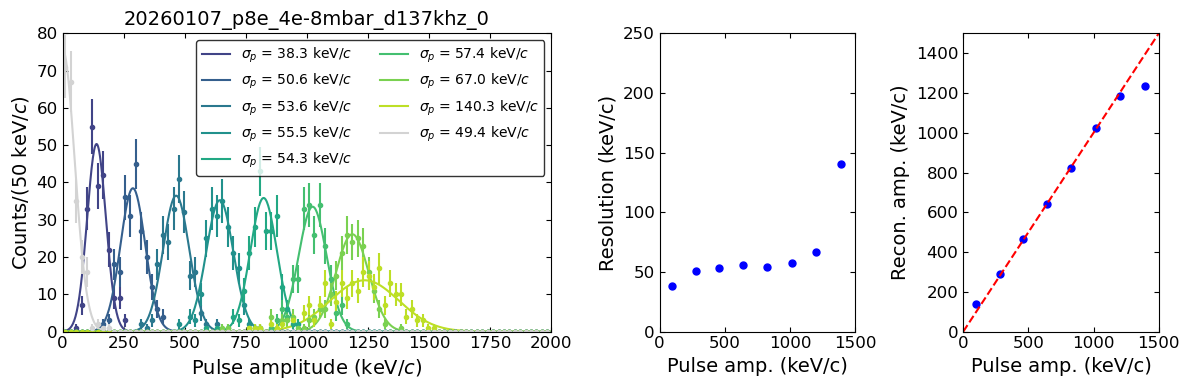

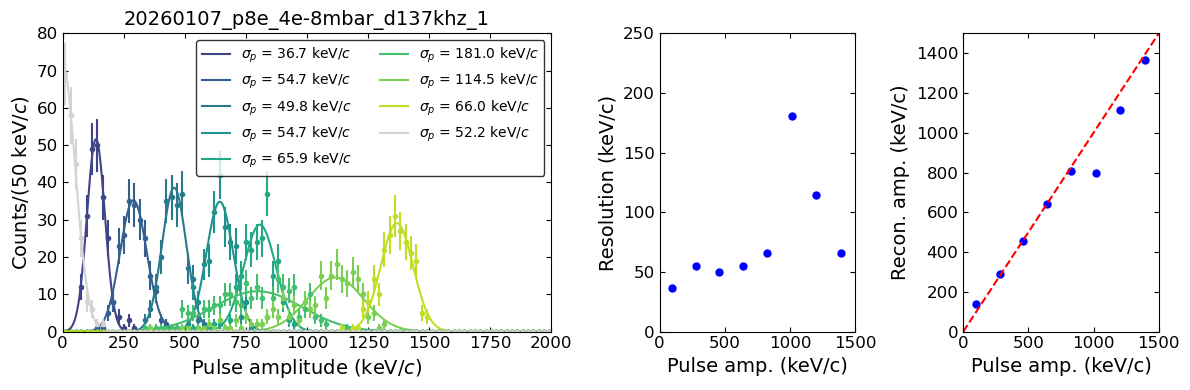

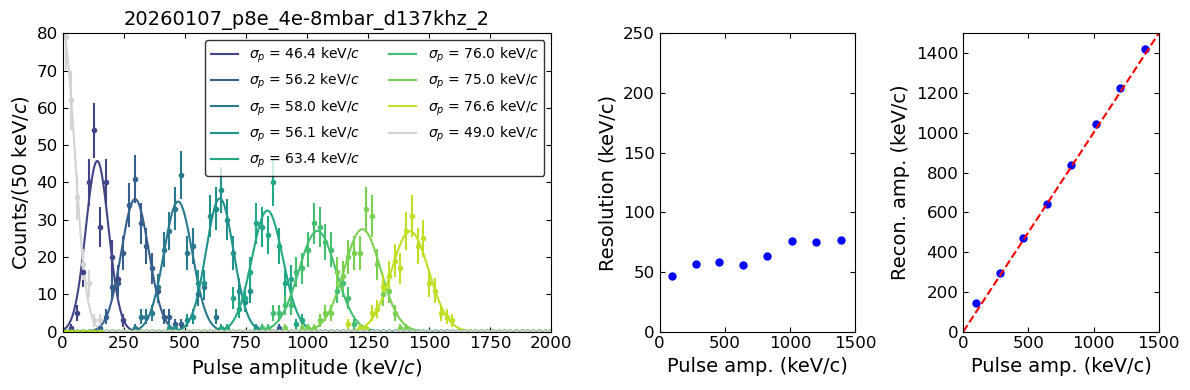

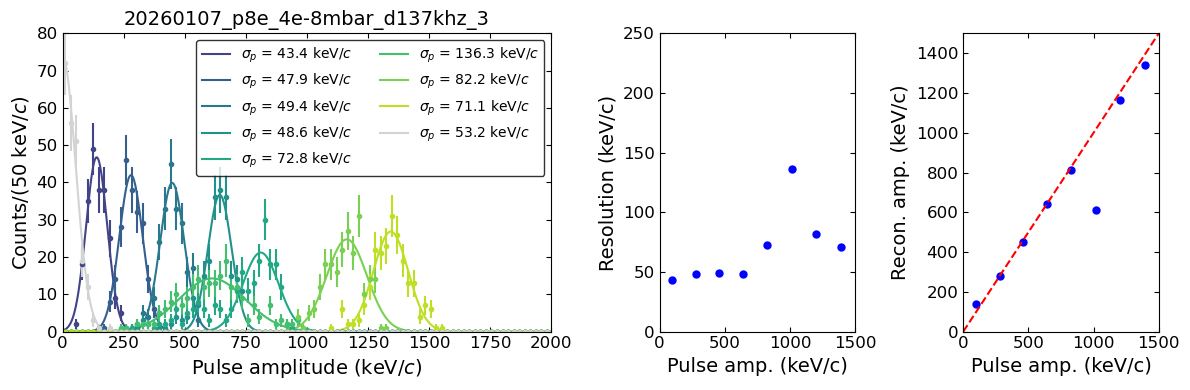

In [59]:
pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395])
amps_all = [amps_all_0, amps_all_1, amps_all_2, amps_all_3]
amps_noise_all = [amps_noise_0, amps_noise_1, amps_noise_2, amps_noise_3]

for j in range(len(amps_all)):
    bins = np.arange(0, 3000, 25) / 7618.48509248859
    hhs, bcs, gps = utils.fit_amps_gaus(amps_all[j], bins=bins, noise=False, return_bins=False)
    hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise_all[j]], bins=bins, noise=True, return_bins=False)

    amp2kevs = pulse_amp / np.asarray(gps).T[1]
    amp2kev = amp2kevs[3]

    print('amp2keV', amp2kev)
    print('Fitted sigma:', np.asarray(gps).T[2]*amp2kev, 'keV/c')

    xx = np.linspace(0, np.max(bcs[0]), 1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), width_ratios=[2.5, 1, 1])

    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0.2, 0.9, 8))
    for i in range(pulse_amp.size):
        axes[0].errorbar(bcs[i]*amp2kev, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
        axes[0].plot(xx*amp2kev, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])

    axes[0].errorbar(bcs_noise[0]*amp2kev, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
    axes[0].plot(xx*amp2kev, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev:.1f} keV/$c$', color='lightgrey')

    print('Noise level', gps_noise[0][1], 'arb. amplitude')
    print('Noise level', gps_noise[0][1]*amp2kev, 'keV/c')

    axes[0].set_xlim(0, 2000)
    axes[0].legend(edgecolor='k', ncol=2, fontsize=10)
    axes[0].set_xlabel(r'Pulse amplitude (keV/$c$)')
    axes[0].set_ylabel(r'Counts/(50 keV/$c$)')

    if j == 4:
        axes[0].set_title(f'Combined dataset')
        axes[0].set_ylim(0, 320)
    else:
        axes[0].set_title(f'{datasets[j]}')
        axes[0].set_ylim(0, 80)

    axes[1].plot(pulse_amp, np.asarray(gps).T[2]*amp2kev, 'b.', markersize=10)
    axes[1].set_xlim(0, 1500)
    axes[1].set_ylim(0, 250)
    axes[1].set_xlabel('Pulse amp. (keV/c)')
    axes[1].set_ylabel('Resolution (keV/c)')
    # axes[1].plot(np.linspace(0, 1500, 50), np.full(50, gps_noise[0][1]*amp2kev_all), 'k--')

    axes[2].plot(pulse_amp, np.asarray(gps).T[1]*amp2kev, 'b.', markersize=10)
    axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
    axes[2].set_xlim(0, 1500)
    axes[2].set_ylim(0, 1500)
    axes[2].set_xlabel('Pulse amp. (keV/c)')
    axes[2].set_ylabel('Recon. amp. (keV/c)')

    fig.tight_layout()

#### Hand select the well-reconstructed pulses

In [65]:
good_recon = np.asarray([np.asarray([True, True, True, True, True, True, True, False]),
                         np.asarray([True, True, True, True, True, False, False, True]),
                         np.asarray([True, True, True, True, True, True, True, True]),
                         np.asarray([True, True, True, True, False, False, True, True])])

good_amps_all = []
for i in range(pulse_amp.size):
    good_amps = []

    for j, amps in enumerate(amps_all):
        if good_recon[j][i]:
            good_amps.append(amps[i])
        
    good_amps_all.append(np.concatenate(good_amps))

good_amps_noise_all = np.concatenate(amps_noise_all)

amp2keV 6935.448138438464
Fitted sigma: [41.66139712 53.36815029 54.94759034 59.54383951 63.73736803 69.30354339
 77.3562564  81.96256156] keV/c
Noise level 0.007440260224510383 arb. amplitude
Noise level 51.60153892357829 keV/c


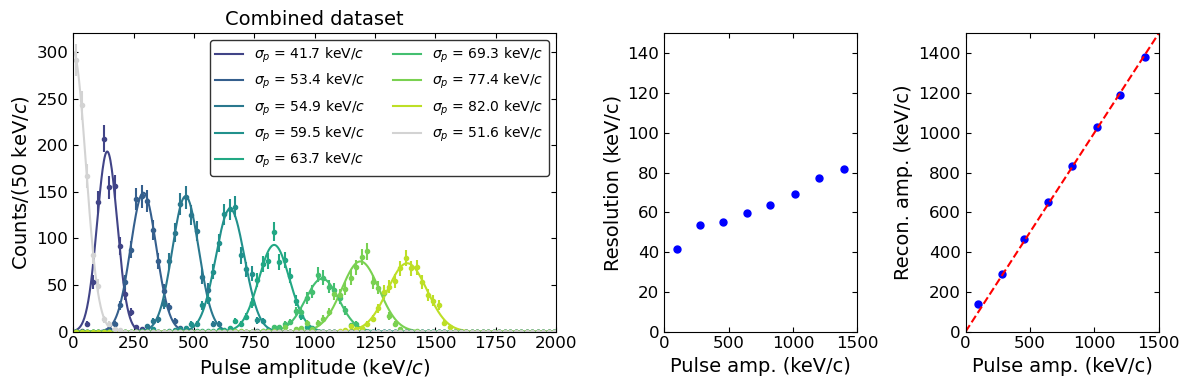

In [74]:
from scipy.optimize import curve_fit

def model_func(x, a):
    return a * x

bins = np.arange(0, 3000, 25) / 7618.48509248859
hhs, bcs, gps = utils.fit_amps_gaus(good_amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([good_amps_noise_all], bins=bins, noise=True, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev = curve_fit(model_func, np.asarray(gps).T[1][1:], pulse_amp[1:])[0][0]

print('amp2keV', amp2kev)
print('Fitted sigma:', np.asarray(gps).T[2]*amp2kev, 'keV/c')

xx = np.linspace(0, np.max(bcs[0]), 1000)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), width_ratios=[2.5, 1, 1])

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(pulse_amp.size):
    axes[0].errorbar(bcs[i]*amp2kev, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    axes[0].plot(xx*amp2kev, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])

axes[0].errorbar(bcs_noise[0]*amp2kev, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
axes[0].plot(xx*amp2kev, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev:.1f} keV/$c$', color='lightgrey')

print('Noise level', gps_noise[0][1], 'arb. amplitude')
print('Noise level', gps_noise[0][1]*amp2kev, 'keV/c')

axes[0].set_xlim(0, 2000)
axes[0].legend(edgecolor='k', ncol=2, fontsize=10)
axes[0].set_xlabel(r'Pulse amplitude (keV/$c$)')
axes[0].set_ylabel(r'Counts/(50 keV/$c$)')

axes[0].set_title(f'Combined dataset')
axes[0].set_ylim(0, 320)

axes[1].plot(pulse_amp, np.asarray(gps).T[2]*amp2kev, 'b.', markersize=10)
axes[1].set_xlim(0, 1500)
axes[1].set_ylim(0, 150)
axes[1].set_xlabel('Pulse amp. (keV/c)')
axes[1].set_ylabel('Resolution (keV/c)')
# axes[1].plot(np.linspace(0, 1500, 50), np.full(50, gps_noise[0][1]*amp2kev_all), 'k--')

axes[2].plot(pulse_amp, np.asarray(gps).T[1]*amp2kev, 'b.', markersize=10)
axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
axes[2].set_xlim(0, 1500)
axes[2].set_ylim(0, 1500)
axes[2].set_xlabel('Pulse amp. (keV/c)')
axes[2].set_ylabel('Recon. amp. (keV/c)')

fig.tight_layout()

In [14]:
bandpass_lb, bandpass_ub = (39000, 74000) # Analysis bandwidth in Hz
lowpass_order = 3
positive_pulse = True
notch_freq = 137000

fit_window_length = 2**19                 # Window length to fit for frequencies
analysis_window_length = 2**18

In [4]:
sphere = 'sphere_20260105'
dataset = '20260107_p8e_4e-8mbar_d137khz_0'
data_prefix = '20260107_dfg_p8e_200ns_20v_'

data_folder = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{dataset}'

combined_path = os.path.join(data_folder, f'{data_prefix}*.hdf5')
data_files = glob.glob(combined_path)

In [6]:
data_file = data_files[0]

dtt, nn = utils.load_timestreams(data_file, ['D', 'G'])
fs = int(np.ceil(1 / dtt))
zz, dd = nn[0], nn[1]

In [10]:
zz = utils.notch_filtered(zz, fs, f0=notch_freq, q=50)
# First loosely bandpass the z signal
zz_bp = utils.bandpass_filtered(zz, fs, bandpass_lb, bandpass_ub, order=lowpass_order)

(10.0, 100.0)

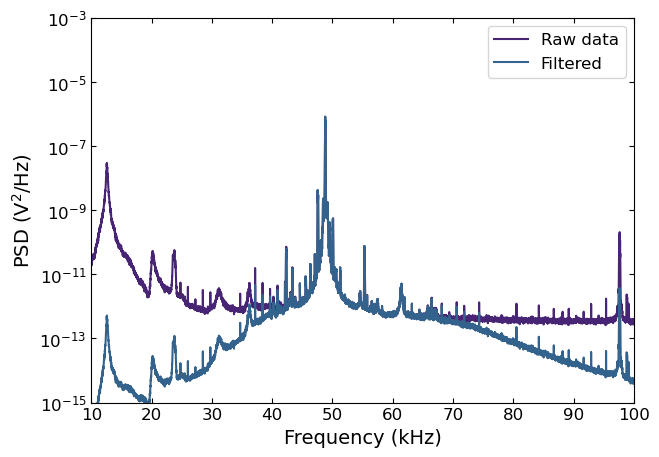

In [11]:
ff, pp = welch(zz, fs=fs, nperseg=2**19)
ff_bp, pp_bp = welch(zz_bp, fs=fs, nperseg=2**19)

plt.plot(ff/1000, pp, label='Raw data')
plt.plot(ff_bp/1000, pp_bp, label='Filtered')

plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (V$^2$/Hz)')
plt.yscale('log')
plt.ylim(1e-15, 1e-3)
plt.xlim(10, 100)


In [12]:
trigger_level = 0.5 * positive_pulse
pulse_indices = utils.get_pulse_idx(dd, trigger_level, positive_pulse)
noise_indices = np.ceil(0.5 * (pulse_indices[:-1] + pulse_indices[1:])).astype(np.int64)

In [15]:
pulse_idx = pulse_indices[1]
window, f, f_lp, amp = utils.recon_pulse(pulse_idx, dtt, zz_bp, dd, 
                                         analysis_window_length, 
                                         fit_window_length, 250, 20, bandpass_ub, lowpass_order)

In [27]:
def get_pulse_shape(zz_bp_in_window, f_lp, amp, length=1500, is_scaled=False):
    if not is_scaled:
        f_lp_scaled = f_lp / 1e9
    else:
        f_lp_scaled = f_lp
    pulse_idx_in_win = np.argmin(np.abs(np.abs(f_lp_scaled) - amp))
    print(pulse_idx_in_win)

    if f_lp_scaled[pulse_idx_in_win] > 0:
        polarity = 1
    else:
        polarity = -1

    ret = polarity * f_lp_scaled[pulse_idx_in_win - length : pulse_idx_in_win + length]
    zz_ret = zz_bp_in_window[pulse_idx_in_win - length : pulse_idx_in_win + length]

    # Get 50 us around the maximum amplitude
    return zz_ret, ret

In [29]:
zz_pulse, pulse_shape = get_pulse_shape(zz_bp[window], f_lp, amp, 1500, True)


262265
